In [ ]:
# Bước 4: Lọc ra Top 50 mã tiềm năng
# =====================

top_50 = []
for ticker in all_tickers:
    filepath = f"data_vnstock/{ticker}.csv"
    if os.path.exists(filepath):
        df = pd.read_csv(filepath)
        try:
            df_feat = create_xgboost_features(df)
            last_row = df_feat.iloc[-1:][['return_5', 'return_10', 'ma_5', 'ma_10', 'volatility_5']].values
            prob = model_xgb.predict_proba(last_row)[0][1]
            top_50.append((ticker, prob))
        except:
            continue

top_50_sorted = sorted(top_50, key=lambda x: x[1], reverse=True)[:50]
top_tickers = [t[0] for t in top_50_sorted]


In [ ]:
# Bước 5: Dự báo chi tiết với LSTM (có lưu mô hình tốt nhất)
# =====================

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint, EarlyStopping

def preprocess_lstm_data(df, window=50):
    close = df['close'].astype(float).values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(close)
    X = [scaled[i - window:i] for i in range(window, len(scaled))]
    y = [scaled[i][0] for i in range(window, len(scaled))]
    return np.array(X), np.array(y), scaler

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(32))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

os.makedirs("models", exist_ok=True)

for ticker in top_tickers:
    filepath = f"data_vnstock/{ticker}.csv"
    df = pd.read_csv(filepath)
    if len(df) < 100: continue
    X_lstm, y_lstm, scaler = preprocess_lstm_data(df)
    model_lstm = build_lstm_model((X_lstm.shape[1], X_lstm.shape[2]))

    checkpoint_path = f"models/lstm_{ticker}.h5"
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='loss', save_best_only=True, mode='min', verbose=0)
    early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

    model_lstm.fit(
        X_lstm, y_lstm,
        epochs=100,
        batch_size=32,
        verbose=0,
        callbacks=[checkpoint, early_stop]
    )

    model_lstm = load_model(checkpoint_path)
    predicted = model_lstm.predict(X_lstm[-1].reshape(1, X_lstm.shape[1], X_lstm.shape[2]))
    price_pred = scaler.inverse_transform(predicted)[0][0]
    print(f"{ticker}: Dự đoán giá tương lai: {price_pred:.2f}")


In [1]:
!pip install vnstock xgboost keras h5py pandas numpy --quiet


In [28]:
!pip install -U scikit-learn



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
# =====================
# Bước 1: Lấy danh sách mã và dữ liệu lịch sử
# =====================

from vnstock import Vnstock
import os
import pandas as pd
import time  # Thêm thư viện time để giới hạn tốc độ gửi request
import xgboost as xgb
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.impute import SimpleImputer
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import h5py
MIN_AVG_VOLUME = 100000
# Tạo danh sách mã
all_tickers = Vnstock().stock(symbol='ACB', source='TCBS').listing.all_symbols()['symbol'].tolist()
request_count = 0


ModuleNotFoundError: No module named 'vnstock'

In [ ]:

os.makedirs("data_vnstock", exist_ok=True)

# Tải dữ liệu và lưu CSV với delay giữa các request (10 request nghỉ 100s)

for ticker in all_tickers:
    try:
        stock = Vnstock().stock(symbol=ticker, source='VCI')
        df = stock.quote.history(start='2015-06-26', end='2025-06-26')
        if not df.empty:
            df.to_csv(f"data_vnstock/{ticker}.csv", index=False)
            print(f"Lưu thành công: {ticker}")
        request_count += 1
        if request_count % 10 == 0:
            print("\n⏳ Nghỉ 100 giây sau 10 request...")
            time.sleep(100)
        else:
            time.sleep(1)
    except Exception as e:
        print(f"Lỗi với {ticker}: {e}")



Fitting 3 folds for each of 30 candidates, totalling 90 fits


[15:53:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




📊 Đánh giá mô hình XGBoost mới:
🔹 Accuracy Train: 0.7850 | F1 Train: 0.3975
🔹 Accuracy  Test: 0.7496 | F1 Test : 0.3017
✅ Đã lưu mô hình XGBoost lần đầu.


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho AMS (loss: 0.0046)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho ANV (loss: 0.0026)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho API (loss: 0.0035)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho ASP (loss: 0.0024)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho BCC (loss: 0.0032)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho BCG (loss: 0.0027)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho BIG (loss: 0.0015)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho C4G (loss: 0.0036)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho CEO (loss: 0.0027)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho CTX (loss: 0.0052)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho DGT (loss: 0.0042)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho DGW (loss: 0.0025)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho DL1 (loss: 0.0028)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho DRI (loss: 0.0045)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho DTD (loss: 0.0046)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho DTI (loss: 0.0063)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho DXS (loss: 0.0058)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho FCS (loss: 0.0046)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho G36 (loss: 0.0036)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho GKM (loss: 0.0053)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho HAP (loss: 0.0035)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho HHS (loss: 0.0027)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho HSL (loss: 0.0028)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho ITC (loss: 0.0030)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho JVC (loss: 0.0032)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho LDG (loss: 0.0039)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho LGL (loss: 0.0033)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho LIG (loss: 0.0027)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho MPC (loss: 0.0081)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho MST (loss: 0.0033)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho NT2 (loss: 0.0027)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho OIL (loss: 0.0031)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho ORS (loss: 0.0020)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho PSB (loss: 0.0042)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho PSI (loss: 0.0024)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho PTL (loss: 0.0032)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho PVC (loss: 0.0033)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho RYG (loss: 0.0050)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho SCR (loss: 0.0024)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho SMC (loss: 0.0038)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho SVN (loss: 0.0037)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho SZC (loss: 0.0036)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho TLD (loss: 0.0044)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho TNG (loss: 0.0029)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho TVB (loss: 0.0022)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho VBB (loss: 0.0060)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho VFS (loss: 0.0080)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho VHE (loss: 0.0022)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho VNE (loss: 0.0035)


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


✅ Lưu mô hình LSTM mới cho VTD (loss: 0.0036)
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


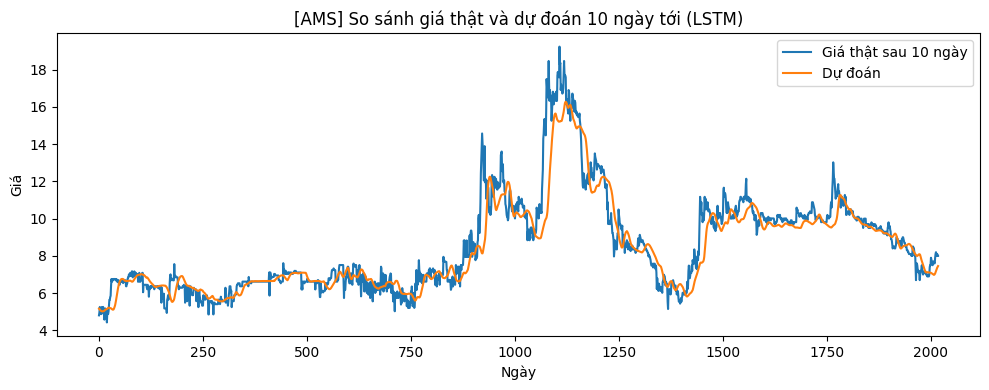

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


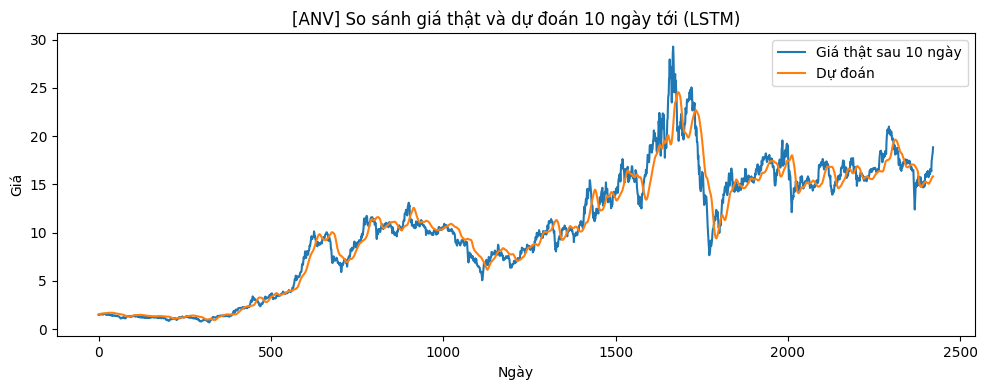

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


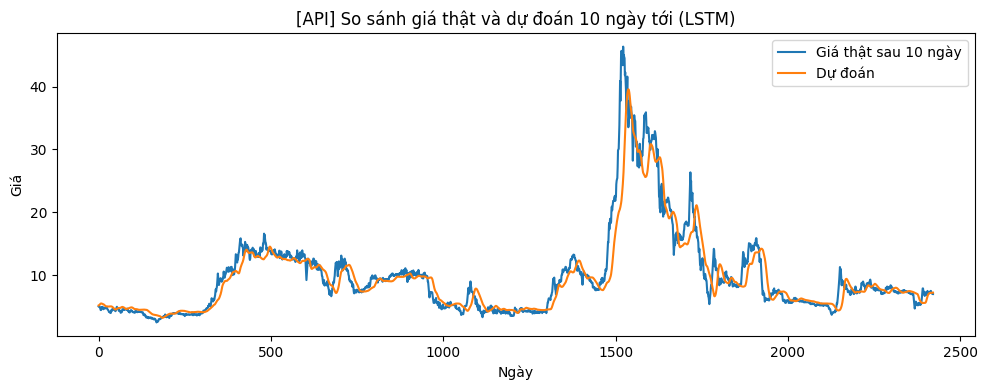

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step


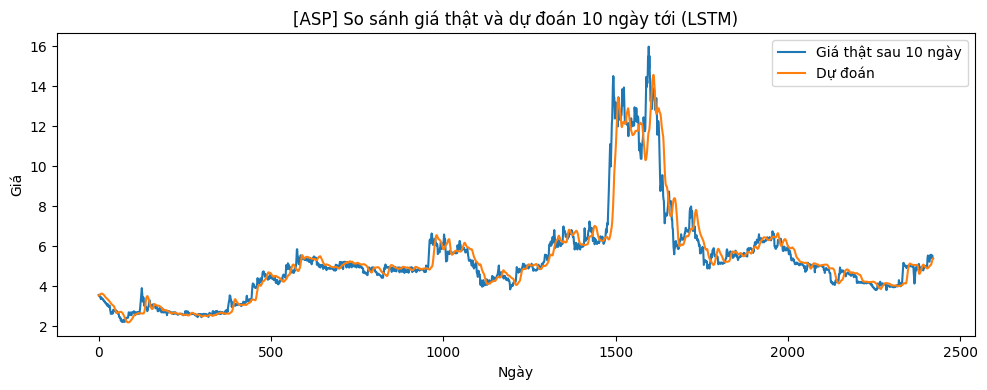

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


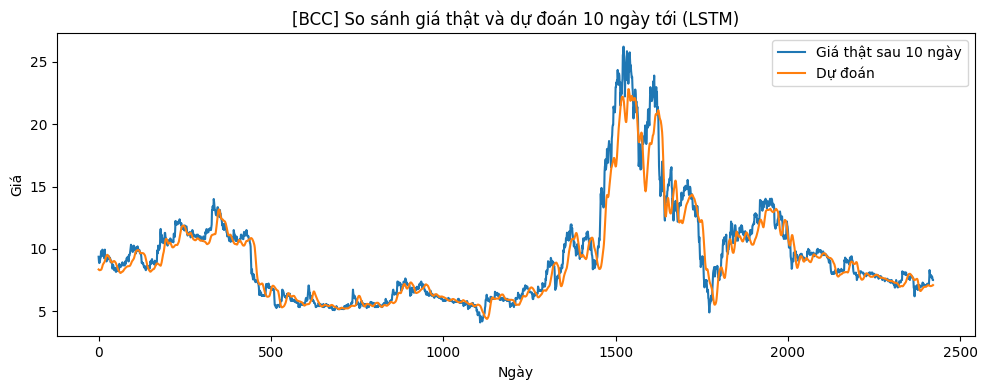

ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x000002251CDDFCD0>>)
Traceback (most recent call last):
  File "e:\Stock Project\.venv\lib\site-packages\jupyter_client\session.py", line 95, in json_packer
    return json.dumps(
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 30-31: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "e:\Stock Project\.venv\lib\site-packages\tornado\ioloop.py", line 758, in _run_callback
    ret = callback()
  File "e:\Stock Project\.venv\lib\site-packages\ipykernel\iostream.py", line 649, in _flush
    self.session.send(
  File "e:\Stock Project\.venv\lib\site-packages\jupyter_client\session.py", line 852, in send
    to_send = self.serialize(msg, ident)
  File "e:\Stock Project\.venv\lib\site-packages\jupyter_client\session.py", line 721, in serialize
    c

 1. SVN        | Hiện tại: 4.70 → Dự đoán sau 10 ngày: 6.11 | Xác suất tăng: 0.8579


 2. LDG        | Hiện tại: 2.67 → Dự đoán sau 10 ngày: 2.22 | Xác suất tăng: 0.8228


 3. DTI        | Hiện tại: 2.50 → Dự đoán sau 10 ngày: 2.97 | Xác suất tăng: 0.8105


 4. HSL        | Hiện tại: 6.53 → Dự đoán sau 10 ngày: 4.77 | Xác suất tăng: 0.7815


 5. LGL        | Hiện tại: 3.99 → Dự đoán sau 10 ngày: 3.15 | Xác suất tăng: 0.7335


 6. PVC        | Hiện tại: 11.60 → Dự đoán sau 10 ngày: 9.85 | Xác suất tăng: 0.7301


 7. DXS        | Hiện tại: 9.20 → Dự đoán sau 10 ngày: 7.76 | Xác suất tăng: 0.7130


 8. ASP        | Hiện tại: 5.39 → Dự đoán sau 10 ngày: 5.39 | Xác suất tăng: 0.6773


 9. DGW        | Hiện tại: 46.00 → Dự đoán sau 10 ngày: 35.70 | Xác suất tăng: 0.6603


10. PTL        | Hiện tại: 2.75 → Dự đoán sau 10 ngày: 2.49 | Xác suất tăng: 0.6571


11. BIG        | Hiện tại: 6.10 → Dự đoán sau 10 ngày: 4.64 | Xác suất tăng: 0.6558


12. FCS        | Hiện tại: 9.30 → Dự đoán sau 10 ngày: 7.18 | Xác suất tăng: 0.6513


13. ANV        | Hiện tại: 18.85 → Dự đoán sau 10 ngày: 15.84 | Xác suất tăng: 0.6249


14. VFS        | Hiện tại: 26.50 → Dự đoán sau 10 ngày: 23.03 | Xác suất tăng: 0.6084


15. MPC        | Hiện tại: 13.60 → Dự đoán sau 10 ngày: 11.31 | Xác suất tăng: 0.6052
16. OIL        | Hiện tại: 11.90 → Dự đoán sau 10 ngày: 10.40 | Xác suất tăng: 0.5790


17. JVC        | Hiện tại: 5.20 → Dự đoán sau 10 ngày: 4.99 | Xác suất tăng: 0.5771


18. DL1        | Hiện tại: 8.60 → Dự đoán sau 10 ngày: 9.12 | Xác suất tăng: 0.5743


19. BCC        | Hiện tại: 7.50 → Dự đoán sau 10 ngày: 7.09 | Xác suất tăng: 0.5727


20. G36        | Hiện tại: 9.30 → Dự đoán sau 10 ngày: 9.41 | Xác suất tăng: 0.5654


21. SCR        | Hiện tại: 7.25 → Dự đoán sau 10 ngày: 7.34 | Xác suất tăng: 0.5630


22. BCG        | Hiện tại: 2.97 → Dự đoán sau 10 ngày: 2.56 | Xác suất tăng: 0.5610


23. CTX        | Hiện tại: 17.90 → Dự đoán sau 10 ngày: 12.54 | Xác suất tăng: 0.5578


24. VTD        | Hiện tại: 9.70 → Dự đoán sau 10 ngày: 9.08 | Xác suất tăng: 0.5477


25. MST        | Hiện tại: 5.90 → Dự đoán sau 10 ngày: 6.17 | Xác suất tăng: 0.5405


26. C4G        | Hiện tại: 8.50 → Dự đoán sau 10 ngày: 8.16 | Xác suất tăng: 0.5320


27. TVB        | Hiện tại: 8.58 → Dự đoán sau 10 ngày: 7.72 | Xác suất tăng: 0.5315


28. PSB        | Hiện tại: 4.70 → Dự đoán sau 10 ngày: 4.15 | Xác suất tăng: 0.5241


29. PSI        | Hiện tại: 6.80 → Dự đoán sau 10 ngày: 6.72 | Xác suất tăng: 0.5175


30. DTD        | Hiện tại: 17.30 → Dự đoán sau 10 ngày: 16.83 | Xác suất tăng: 0.5151


31. LIG        | Hiện tại: 3.00 → Dự đoán sau 10 ngày: 2.98 | Xác suất tăng: 0.5149


32. HHS        | Hiện tại: 15.10 → Dự đoán sau 10 ngày: 14.98 | Xác suất tăng: 0.5113


33. TNG        | Hiện tại: 20.40 → Dự đoán sau 10 ngày: 18.60 | Xác suất tăng: 0.5076


34. GKM        | Hiện tại: 3.90 → Dự đoán sau 10 ngày: 3.66 | Xác suất tăng: 0.5036


35. VHE        | Hiện tại: 4.20 → Dự đoán sau 10 ngày: 4.31 | Xác suất tăng: 0.5006


36. ITC        | Hiện tại: 14.70 → Dự đoán sau 10 ngày: 13.80 | Xác suất tăng: 0.4986


37. NT2        | Hiện tại: 19.20 → Dự đoán sau 10 ngày: 18.38 | Xác suất tăng: 0.4976


38. SZC        | Hiện tại: 37.85 → Dự đoán sau 10 ngày: 33.86 | Xác suất tăng: 0.4957


39. API        | Hiện tại: 7.00 → Dự đoán sau 10 ngày: 7.23 | Xác suất tăng: 0.4916


40. VBB        | Hiện tại: 9.65 → Dự đoán sau 10 ngày: 9.50 | Xác suất tăng: 0.4904


41. TLD        | Hiện tại: 6.88 → Dự đoán sau 10 ngày: 6.73 | Xác suất tăng: 0.4890


42. SMC        | Hiện tại: 10.40 → Dự đoán sau 10 ngày: 10.16 | Xác suất tăng: 0.4889


43. HAP        | Hiện tại: 5.94 → Dự đoán sau 10 ngày: 5.81 | Xác suất tăng: 0.4828


44. CEO        | Hiện tại: 18.00 → Dự đoán sau 10 ngày: 18.89 | Xác suất tăng: 0.4802


45. DGT        | Hiện tại: 5.00 → Dự đoán sau 10 ngày: 4.91 | Xác suất tăng: 0.4798


46. AMS        | Hiện tại: 8.00 → Dự đoán sau 10 ngày: 7.45 | Xác suất tăng: 0.4753


47. RYG        | Hiện tại: 12.00 → Dự đoán sau 10 ngày: 12.86 | Xác suất tăng: 0.4742


48. ORS        | Hiện tại: 9.14 → Dự đoán sau 10 ngày: 8.93 | Xác suất tăng: 0.4649


49. DRI        | Hiện tại: 13.00 → Dự đoán sau 10 ngày: 12.69 | Xác suất tăng: 0.4634
50. VNE        | Hiện tại: 4.95 → Dự đoán sau 10 ngày: 5.30 | Xác suất tăng: 0.4622


In [2]:
import os
import json
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score
from sklearn.impute import SimpleImputer
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import h5py
import joblib

MIN_AVG_VOLUME = 100000  # Ngưỡng lọc khối lượng giao dịch

def create_xgboost_features(df):
    df = df.copy()
    df['close'] = df['close'].astype(float)
    df['volume'] = df['volume'].astype(float)
    df['return_5'] = df['close'].pct_change(5)
    df['return_10'] = df['close'].pct_change(10)
    df['ma_5'] = df['close'].rolling(5).mean()
    df['ma_10'] = df['close'].rolling(10).mean()
    df['volatility_5'] = df['close'].rolling(5).std()
    df['volume_ma_20'] = df['volume'].rolling(20).mean()
    df['sma_20'] = df['close'].rolling(window=20).mean()
    df['bb_upper'] = df['sma_20'] + 2 * df['close'].rolling(window=20).std()
    df['bb_lower'] = df['sma_20'] - 2 * df['close'].rolling(window=20).std()
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))
    ema_12 = df['close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema_12 - ema_26
    df['ema_50'] = df['close'].ewm(span=50, adjust=False).mean()
    # ADX Calculation with safety check
    df['high'] = df['high'].astype(float)
    df['low'] = df['low'].astype(float)
    df['prev_close'] = df['close'].shift(1)
    df['tr1'] = df['high'] - df['low']
    df['tr2'] = abs(df['high'] - df['prev_close'])
    df['tr3'] = abs(df['low'] - df['prev_close'])
    df['tr'] = df[['tr1', 'tr2', 'tr3']].max(axis=1)
    df['atr_14'] = df['tr'].rolling(window=14).mean()
    df['up_move'] = df['high'] - df['high'].shift(1)
    df['down_move'] = df['low'].shift(1) - df['low']
    df['plus_dm'] = np.where((df['up_move'] > df['down_move']) & (df['up_move'] > 0), df['up_move'], 0.0)
    df['minus_dm'] = np.where((df['down_move'] > df['up_move']) & (df['down_move'] > 0), df['down_move'], 0.0)
    df['plus_di'] = 100 * (df['plus_dm'].rolling(window=14).mean() / df['atr_14'])
    df['minus_di'] = 100 * (df['minus_dm'].rolling(window=14).mean() / df['atr_14'])
    denominator = df['plus_di'] + df['minus_di']
    numerator = abs(df['plus_di'] - df['minus_di'])
    df['adx'] = np.where((denominator == 0) | (denominator.isna()), 0, 100 * numerator / denominator)

    df = df.dropna()
    return df

def create_labels(df, horizon=10, threshold=0.12):
    df = df.copy()
    df['future_return'] = df['close'].shift(-horizon) / df['close'] - 1
    df['label'] = (df['future_return'] >= threshold).astype(int)
    return df.dropna()

features = [
    'return_5', 'return_10', 'ma_5', 'ma_10',
    'volatility_5', 'volume_ma_20',
    'bb_upper', 'bb_lower', 'rsi', 'macd', 'ema_50', 'adx'
]

all_tickers = [f.replace('.csv', '') for f in os.listdir("data_vnstock") if f.endswith(".csv")]

X, y = [], []
qualified_tickers = []
ticker_data_cache = {}

for ticker in all_tickers:
    filepath = f"data_vnstock/{ticker}.csv"
    df = pd.read_csv(filepath)
    if len(df) < 100:
        continue

    df['time'] = pd.to_datetime(df['time'])
    last_date = df['time'].max()
    if (pd.Timestamp.today() - last_date).days > 90:
        continue

    recent_dates = df['time'].dt.date.unique()
    recent_30d = pd.Timestamp.today().date() - pd.to_timedelta(30, unit='d')
    active_days_last_30 = [d for d in recent_dates if d >= recent_30d]
    if len(active_days_last_30) < 10:
        continue

    if df['volume'].tail(20).mean() < MIN_AVG_VOLUME:
        continue

    last_20_volume = df['volume'].tail(20)
    if (last_20_volume > 0).sum() < 15:
        continue

    df_feat = create_xgboost_features(df)
    if df_feat.empty:
        continue

    df_lab = create_labels(df_feat)
    X.append(df_lab[features].values)
    y.append(df_lab['label'].values)

    qualified_tickers.append(ticker)
    ticker_data_cache[ticker] = df_feat

# Xử lý dữ liệu đầu vào
X = np.vstack(X)
y = np.hstack(y)
X[np.isinf(X)] = np.nan
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)
mask = np.isfinite(X).all(axis=1)
X, y = X[mask], y[mask]

# Chia tập huấn luyện / kiểm tra
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# Tính trọng số nhãn để xử lý mất cân bằng
pos_weight = len(y_train[y_train == 0]) / max(1, len(y_train[y_train == 1]))

# Grid tìm tham số tốt nhất
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0]
}

random_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(scale_pos_weight=pos_weight, use_label_encoder=False, eval_metric='logloss'),
    param_distributions=param_grid,
    n_iter=30,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)
model = random_search.best_estimator_

# Dự đoán
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Đánh giá
f1_train = f1_score(y_train, y_train_pred)
acc_train = accuracy_score(y_train, y_train_pred)
f1_val = f1_score(y_val, y_val_pred)
acc_val = accuracy_score(y_val, y_val_pred)

print("\n📊 Đánh giá mô hình XGBoost mới:")
print(f"🔹 Accuracy Train: {acc_train:.4f} | F1 Train: {f1_train:.4f}")
print(f"🔹 Accuracy  Test: {acc_val:.4f} | F1 Test : {f1_val:.4f}")

# Lưu mô hình nếu tốt hơn
os.makedirs("models", exist_ok=True)
model_path = "models/best_xgboost_model.json"

if not os.path.exists(model_path):
    model.save_model(model_path)
    print("✅ Đã lưu mô hình XGBoost lần đầu.")
else:
    old_model = xgb.XGBClassifier(use_label_encoder=False)
    old_model.load_model(model_path)
    old_model.set_params(eval_metric='logloss')

    y_old_val = old_model.predict(X_val)
    f1_old = f1_score(y_val, y_old_val)
    acc_old = accuracy_score(y_val, y_old_val)

    print(f"\n📉 Mô hình cũ: Accuracy = {acc_old:.4f} | F1 = {f1_old:.4f}")
    print(f"📈 Mô hình mới: Accuracy = {acc_val:.4f} | F1 = {f1_val:.4f}")

    if f1_val > f1_old:
        model.save_model(model_path)
        print(f"✅ Ghi đè mô hình cũ (F1 cũ = {f1_old:.4f} → mới = {f1_val:.4f})")
    else:
        print(f"⛔ Không lưu, mô hình hiện tại kém hơn hoặc bằng (F1 mới = {f1_val:.4f} ≤ cũ = {f1_old:.4f})")

# Chọn top 50 mã tiềm năng và huấn luyện LSTM
trained_ticker_path = "models/lstm_trained_tickers.json"
if os.path.exists(trained_ticker_path):
    with open(trained_ticker_path, "r") as f:
        trained_tickers = set(json.load(f))
else:
    trained_tickers = set()

model_xgb = xgb.XGBClassifier()
model_xgb.load_model("models/best_xgboost_model.json")

sorted_top = []
for ticker in qualified_tickers:
    try:
        df_feat = ticker_data_cache[ticker]
        last_row = df_feat.iloc[-1:][features].values
        prob = model_xgb.predict_proba(last_row)[0][1]
        sorted_top.append((ticker, prob))
    except:
        continue

sorted_top = sorted(sorted_top, key=lambda x: x[1], reverse=True)[:50]
top_tickers = [t[0] for t in sorted_top]
trained_tickers.update(top_tickers)

with open(trained_ticker_path, "w") as f:
    json.dump(sorted(trained_tickers), f)
    
# Huấn luyện LSTM
data_h5 = h5py.File("models/lstm_train_data.h5", "w")

for ticker in sorted(trained_tickers):
    filepath = f"data_vnstock/{ticker}.csv"
    if not os.path.exists(filepath): continue
    df = pd.read_csv(filepath)
    if len(df) < 100: continue
    df['close'] = df['close'].astype(float)
    close = df['close'].values.reshape(-1, 1)
    
    # Chuẩn hoá
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(close)
    joblib.dump(scaler, f"models/scaler_{ticker}.pkl")

    # Sliding window
    window = 70
    X_lstm, y_lstm = [], []
    for i in range(window, len(scaled)):
        if i + 10 >= len(scaled): break
        X_lstm.append(scaled[i - window:i])
        y_lstm.append(scaled[i + 10][0])
    X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

    final_path = f"models/lstm_{ticker}.h5"

    def build_model():
        model = Sequential([
            LSTM(64, return_sequences=True, input_shape=(X_lstm.shape[1], X_lstm.shape[2])),
            LSTM(32),
            Dropout(0.3),
            Dense(1)
        ])
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
        return model

    model = build_model()
    cp_path = f"models/tmp_lstm_{ticker}.h5"
    cp = ModelCheckpoint(cp_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)

    history = model.fit(
        X_lstm, y_lstm,
        epochs=150,
        batch_size=32,
        validation_split=0.1,
        verbose=0,
        callbacks=[cp, es]
    )

    # So sánh với mô hình cũ (nếu có)
    new_loss = model.evaluate(X_lstm, y_lstm, verbose=0)[0]
    if os.path.exists(final_path):
        old_model = load_model(final_path)
        old_loss = old_model.evaluate(X_lstm, y_lstm, verbose=0)[0]
        if new_loss < old_loss:
            os.replace(cp_path, final_path)
            print(f"✅ Cập nhật mô hình LSTM cho {ticker} (loss: {old_loss:.4f} → {new_loss:.4f})")
        else:
            print(f"⛔ Không cập nhật mô hình {ticker} (loss mới: {new_loss:.4f} ≥ cũ: {old_loss:.4f})")
    else:
        os.replace(cp_path, final_path)
        print(f"✅ Lưu mô hình LSTM mới cho {ticker} (loss: {new_loss:.4f})")

    # Lưu loss history
    with open(f"models/loss_history_{ticker}.json", "w") as f:
        json.dump(history.history, f)

    # Lưu dữ liệu huấn luyện
    grp = data_h5.create_group(ticker)
    grp.create_dataset("X", data=X_lstm)
    grp.create_dataset("y", data=y_lstm)

data_h5.close()

# Trực quan hóa
for ticker in sorted(list(trained_tickers))[:5]:
    filepath = f"data_vnstock/{ticker}.csv"
    df = pd.read_csv(filepath)
    if len(df) < 100: continue
    df['close'] = df['close'].astype(float)
    close = df['close'].values.reshape(-1, 1)
    scaler_path = f"models/scaler_{ticker}.pkl"
    if not os.path.exists(scaler_path): continue
    scaler = joblib.load(scaler_path)
    scaled = scaler.transform(close)

    window = 70
    X_lstm = [scaled[i - window:i] for i in range(window, len(scaled)) if i + 10 < len(scaled)]
    y_lstm = [scaled[i + 10][0] for i in range(window, len(scaled)) if i + 10 < len(scaled)]
    X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

    model_path = f"models/lstm_{ticker}.h5"
    if not os.path.exists(model_path): continue
    model = load_model(model_path)

    y_pred = model.predict(X_lstm)
    actual = scaler.inverse_transform(np.array(y_lstm).reshape(-1, 1)).flatten()
    predicted = scaler.inverse_transform(y_pred).flatten()

    plt.figure(figsize=(10, 4))
    plt.plot(actual, label="Giá thật sau 10 ngày")
    plt.plot(predicted, label="Dự đoán")
    plt.title(f"[{ticker}] So sánh giá thật và dự đoán 10 ngày tới (LSTM)")
    plt.xlabel("Ngày")
    plt.ylabel("Giá")
    plt.legend()
    plt.tight_layout()
    plt.show()


# In kết quả
ticker_forecasts = []
print("\n\ud83d\udcc8 Top 50 cổ phiếu tiềm năng nhất theo XGBoost + LSTM:")
for i, (ticker, prob) in enumerate(sorted_top, 1):
    model_path = f"models/lstm_{ticker}.h5"
    scaler_path = f"models/scaler_{ticker}.pkl"
    data_path = f"data_vnstock/{ticker}.csv"

    if not all(os.path.exists(p) for p in [model_path, scaler_path, data_path]):
        continue

    df = pd.read_csv(data_path)
    df['close'] = df['close'].astype(float)
    current_price = df['close'].iloc[-1]
    close = df['close'].values.reshape(-1, 1)

    scaler = joblib.load(scaler_path)
    scaled = scaler.transform(close)
    window = 70
    X_lstm = [scaled[i - window:i] for i in range(window, len(scaled)) if i + 10 < len(scaled)]
    X_lstm = np.array(X_lstm)

    model = load_model(model_path)
    y_pred = model.predict(X_lstm, verbose=0)
    future_price = scaler.inverse_transform(y_pred)[-1][0]

    print(f"{i:2}. {ticker:10s} | Hiện tại: {current_price:,.2f} → Dự đoán sau 10 ngày: {future_price:,.2f} | Xác suất tăng: {prob:.4f}")
    ticker_forecasts.append((ticker, current_price, future_price, prob))



In [ ]:



for ticker in top_tickers[:10]:
    filepath = f"data_vnstock/{ticker}.csv"
    df = pd.read_csv(filepath)
    if len(df) < 100: continue

    X_lstm, y_lstm, scaler = preprocess_lstm_data(df)

    # Tách tập test (10%)
    test_size = int(len(X_lstm) * 0.1)
    X_test = X_lstm[-test_size:]
    y_test = y_lstm[-test_size:]

    # Load model đã lưu
    model = load_model(f"models/lstm_{ticker}.h5")
    y_pred_scaled = model.predict(X_test)
    y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_true = scaler.inverse_transform(y_pred_scaled).flatten()

    # Vẽ biểu đồ
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_true, label="Giá thật")
    plt.plot(y_pred_true, label="Dự đoán")
    plt.title(f"[{ticker}] So sánh giá thật và dự đoán (LSTM)")
    plt.xlabel("Ngày")
    plt.ylabel("Giá")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [36]:
import os
import json
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import h5py
import joblib
from imblearn.over_sampling import SMOTE


MIN_AVG_VOLUME = 100000  # Ngưỡng lọc khối lượng giao dịch

def create_xgboost_features(df):
    df = df.copy()
    df['close'] = df['close'].astype(float)
    df['volume'] = df['volume'].astype(float)
    df['return_5'] = df['close'].pct_change(5)
    df['return_10'] = df['close'].pct_change(10)
    df['ma_5'] = df['close'].rolling(5).mean()
    df['ma_10'] = df['close'].rolling(10).mean()
    df['volatility_5'] = df['close'].rolling(5).std()
    df['volume_ma_20'] = df['volume'].rolling(20).mean()
    df['sma_20'] = df['close'].rolling(window=20).mean()
    df['bb_upper'] = df['sma_20'] + 2 * df['close'].rolling(window=20).std()
    df['bb_lower'] = df['sma_20'] - 2 * df['close'].rolling(window=20).std()
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))
    ema_12 = df['close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema_12 - ema_26
    df = df.dropna()
    return df

def create_labels(df, horizon=10, threshold=0.8):
    df = df.copy()
    df['future_return'] = df['close'].shift(-horizon) / df['close'] - 1
    df['label'] = (df['future_return'] >= threshold).astype(int)
    return df.dropna()

features = [
    'return_5', 'return_10', 'ma_5', 'ma_10',
    'volatility_5', 'volume_ma_20',
    'bb_upper', 'bb_lower', 'rsi', 'macd'
]

all_tickers = [f.replace('.csv', '') for f in os.listdir("data_vnstock") if f.endswith(".csv")]

X, y = [], []
qualified_tickers = []
ticker_data_cache = {}

for ticker in all_tickers:
    filepath = f"data_vnstock/{ticker}.csv"
    df = pd.read_csv(filepath)
    if len(df) < 100:
        continue

    df['time'] = pd.to_datetime(df['time'])
    last_date = df['time'].max()
    if (pd.Timestamp.today() - last_date).days > 90:
        continue

    recent_dates = df['time'].dt.date.unique()
    recent_30d = pd.Timestamp.today().date() - pd.to_timedelta(30, unit='d')
    active_days_last_30 = [d for d in recent_dates if d >= recent_30d]
    if len(active_days_last_30) < 10:
        continue

    if df['volume'].tail(20).mean() < MIN_AVG_VOLUME:
        continue

    last_20_volume = df['volume'].tail(20)
    if (last_20_volume > 0).sum() < 10:
        continue

    df_feat = create_xgboost_features(df)
    if df_feat.empty:
        continue

    df_lab = create_labels(df_feat)
    X.append(df_lab[features].values)
    y.append(df_lab['label'].values)

    qualified_tickers.append(ticker)
    ticker_data_cache[ticker] = df_feat

X = np.vstack(X)
y = np.hstack(y)
X[np.isinf(X)] = np.nan
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)
mask = np.isfinite(X).all(axis=1)
X, y = X[mask], y[mask]

# Huấn luyện XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1]
}
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True)
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(),
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_
y_pred = model.predict(X_val)
f1 = f1_score(y_val, y_pred)
print(f"\n🔍 F1 Score mô hình hiện tại: {f1:.4f}")

os.makedirs("models", exist_ok=True)
model_path = "models/best_xgboost_model.json"
if not os.path.exists(model_path):
    model.save_model(model_path)
    print("✅ Đã lưu mô hình XGBoost lần đầu.")
else:
    old_model = xgb.XGBClassifier()
    old_model.load_model(model_path)
    y_old = old_model.predict(X_val)
    f1_old = f1_score(y_val, y_old)
    if f1 > f1_old:
        model.save_model(model_path)
        print(f"✅ Ghi đè mô hình cũ (F1 cũ = {f1_old:.4f})")
    else:
        print(f"⛔ Không lưu, mô hình hiện tại kém hơn (F1 cũ = {f1_old:.4f})")

# Chọn top 50 mã tiềm năng và huấn luyện LSTM
trained_ticker_path = "models/lstm_trained_tickers.json"
if os.path.exists(trained_ticker_path):
    with open(trained_ticker_path, "r") as f:
        trained_tickers = set(json.load(f))
else:
    trained_tickers = set()

model_xgb = xgb.XGBClassifier()
model_xgb.load_model("models/best_xgboost_model.json")

sorted_top = []
for ticker in qualified_tickers:
    try:
        df_feat = ticker_data_cache[ticker]
        last_row = df_feat.iloc[-1:][features].values
        prob = model_xgb.predict_proba(last_row)[0][1]
        sorted_top.append((ticker, prob))
    except:
        continue

sorted_top = sorted(sorted_top, key=lambda x: x[1], reverse=True)[:50]
top_tickers = [t[0] for t in sorted_top]
trained_tickers.update(top_tickers)

with open(trained_ticker_path, "w") as f:
    json.dump(sorted(trained_tickers), f)
    
# Huấn luyện LSTM
data_h5 = h5py.File("models/lstm_train_data.h5", "w")

for ticker in sorted(trained_tickers):
    filepath = f"data_vnstock/{ticker}.csv"
    if not os.path.exists(filepath): continue
    df = pd.read_csv(filepath)
    if len(df) < 100: continue
    df['close'] = df['close'].astype(float)
    close = df['close'].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(close)
    joblib.dump(scaler, f"models/scaler_{ticker}.pkl")

    window = 70
    X_lstm = [scaled[i - window:i] for i in range(window, len(scaled)) if i + 10 < len(scaled)]
    y_lstm = [scaled[i + 10][0] for i in range(window, len(scaled)) if i + 10 < len(scaled)]
    X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

    final_path = f"models/lstm_{ticker}.h5"
    if os.path.exists(final_path):
        model = load_model(final_path)
        model.fit(X_lstm, y_lstm, epochs=50, validation_split=0.1, verbose=0)
        model.save(final_path)
    else:
        model = Sequential([
            LSTM(64, return_sequences=True, input_shape=(X_lstm.shape[1], X_lstm.shape[2])),
            LSTM(32),
            Dropout(0.3),
            Dense(1)
        ])
        model.compile(loss='mean_squared_error', optimizer='adam')

        cp_path = f"models/tmp_lstm_{ticker}.h5"
        cp = ModelCheckpoint(cp_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
        es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(
            X_lstm, y_lstm,
            epochs=150,
            batch_size=32,
            validation_split=0.1,
            verbose=0,
            callbacks=[cp, es]
        )

        os.replace(cp_path, final_path)

    grp = data_h5.create_group(ticker)
    grp.create_dataset("X", data=X_lstm)
    grp.create_dataset("y", data=y_lstm)

data_h5.close()

# Trực quan hóa
for ticker in sorted(list(trained_tickers))[:5]:
    filepath = f"data_vnstock/{ticker}.csv"
    df = pd.read_csv(filepath)
    if len(df) < 100: continue
    df['close'] = df['close'].astype(float)
    close = df['close'].values.reshape(-1, 1)
    scaler_path = f"models/scaler_{ticker}.pkl"
    if not os.path.exists(scaler_path): continue
    scaler = joblib.load(scaler_path)
    scaled = scaler.transform(close)

    window = 70
    X_lstm = [scaled[i - window:i] for i in range(window, len(scaled)) if i + 10 < len(scaled)]
    y_lstm = [scaled[i + 10][0] for i in range(window, len(scaled)) if i + 10 < len(scaled)]
    X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

    model_path = f"models/lstm_{ticker}.h5"
    if not os.path.exists(model_path): continue
    model = load_model(model_path)

    y_pred = model.predict(X_lstm)
    actual = scaler.inverse_transform(np.array(y_lstm).reshape(-1, 1)).flatten()
    predicted = scaler.inverse_transform(y_pred).flatten()

    plt.figure(figsize=(10, 4))
    plt.plot(actual, label="Giá thật sau 10 ngày")
    plt.plot(predicted, label="Dự đoán")
    plt.title(f"[{ticker}] So sánh giá thật và dự đoán 10 ngày tới (LSTM)")
    plt.xlabel("Ngày")
    plt.ylabel("Giá")
    plt.legend()
    plt.tight_layout()
    plt.show()

# In kết quả
print("\n📈 Top 50 cổ phiếu tiềm năng nhất theo XGBoost (xác suất sinh lời):")
for i, (ticker, prob) in enumerate(sorted_top, 1):
    print(f"{i:2}. {ticker:10s} - Xác suất: {prob:.4f}")


Fitting 3 folds for each of 12 candidates, totalling 36 fits


KeyboardInterrupt: 

In [11]:
import sklearn
import xgboost
print("scikit-learn:", sklearn.__version__)
print("xgboost:", xgboost.__version__)

scikit-learn: 1.7.0
xgboost: 3.0.2


In [17]:
!pip install tensorflow


   ---------------------------------------- 0.0/375.7 MB ? eta -:--:--
   ---------------------------------------- 3.4/375.7 MB 20.2 MB/s eta 0:00:19
    --------------------------------------- 7.3/375.7 MB 19.7 MB/s eta 0:00:19
   - -------------------------------------- 17.0/375.7 MB 29.0 MB/s eta 0:00:13
   -- ------------------------------------- 24.9/375.7 MB 30.9 MB/s eta 0:00:12
   --- ------------------------------------ 33.0/375.7 MB 32.3 MB/s eta 0:00:11
   ---- ----------------------------------- 41.2/375.7 MB 33.1 MB/s eta 0:00:11
   ----- ---------------------------------- 49.0/375.7 MB 33.9 MB/s eta 0:00:10
   ------ --------------------------------- 56.6/375.7 MB 34.0 MB/s eta 0:00:10
   ------ --------------------------------- 64.5/375.7 MB 34.5 MB/s eta 0:00:10
   ------- -------------------------------- 72.4/375.7 MB 34.9 MB/s eta 0:00:09
   -------- ------------------------------- 80.5/375.7 MB 35.2 MB/s eta 0:00:09
   --------- ------------------------------ 88.6/37

  You can safely remove it manually.
  You can safely remove it manually.


In [9]:
!pip install pandas numpy xgboost keras h5py vnstock


  Using cached pandas-2.3.0-cp310-cp310-win_amd64.whl.metadata (19 kB)
  Using cached xgboost-3.0.2-py3-none-win_amd64.whl.metadata (2.1 kB)
  Using cached keras-3.10.0-py3-none-any.whl.metadata (6.0 kB)
  Using cached h5py-3.14.0-cp310-cp310-win_amd64.whl.metadata (2.7 kB)
  Using cached vnstock-3.2.6-py3-none-any.whl.metadata (42 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached absl_py-2.3.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached rich-14.0.0-py3-none-any.whl.metadata (18 kB)
  Using cached namex-0.1.0-py3-none-any.whl.metadata (322 bytes)
  Using cached optree-0.16.0-cp310-cp310-win_amd64.whl.metadata (31 kB)
  Using cached ml_dtypes-0.5.1-cp310-cp310-win_amd64.whl.metadata (22 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pydantic-2.11.7-py3-none-any.whl.metadata (67 kB)
  Using cached fake_useragent-2.2.0-py3-none-any.whl.metadata (

In [12]:
import os
import json
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV # Đã thay đổi
from sklearn.metrics import f1_score
from sklearn.impute import SimpleImputer
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import h5py
import joblib
from collections import Counter
from datetime import datetime # Thêm để xử lý ngày tháng

# --- Cấu hình ---
MIN_AVG_VOLUME = 100000 
XGB_PREDICTION_HORIZON = 10 
XGB_PROFIT_THRESHOLD = 0.05 

LSTM_PREDICTION_HORIZON = 10 # Số ngày nhìn về phía trước cho LSTM
LSTM_SEQUENCE_WINDOW = 70 # Độ dài chuỗi dữ liệu đầu vào cho LSTM

# --- Hàm tạo đặc trưng cho XGBoost ---
def create_xgboost_features(df):
    df = df.copy()
    try:
        # Chuyển đổi kiểu dữ liệu an toàn
        df['close'] = pd.to_numeric(df['close'], errors='coerce')
        df['volume'] = pd.to_numeric(df['volume'], errors='coerce')
        df['high'] = pd.to_numeric(df['high'], errors='coerce')
        df['low'] = pd.to_numeric(df['low'], errors='coerce')
        df['open'] = pd.to_numeric(df['open'], errors='coerce') # Cần cho 'open_close_diff'

        # Kiểm tra nếu các cột chính bị NaN sau chuyển đổi, nếu có thì trả về DataFrame rỗng
        if df[['close', 'volume', 'high', 'low', 'open']].isnull().all().any():
            return pd.DataFrame()

        # Tính toán các đặc trưng kỹ thuật
        df['return_5'] = df['close'].pct_change(5)
        df['return_10'] = df['close'].pct_change(10)
        df['ma_5'] = df['close'].rolling(5).mean()
        df['ma_10'] = df['close'].rolling(10).mean()
        df['volatility_5'] = df['close'].rolling(5).std()
        df['volume_ma_20'] = df['volume'].rolling(20).mean()
        
        # Bollinger Bands
        df['sma_20'] = df['close'].rolling(window=20).mean()
        std_20 = df['close'].rolling(window=20).std()
        df['bb_upper'] = df['sma_20'] + 2 * std_20
        df['bb_lower'] = df['sma_20'] - 2 * std_20
        
        # RSI
        delta = df['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        # Tránh chia cho 0 và NaN: thay thế 0 bằng np.nan, sau đó fillna(0) cho rsi
        rs = gain / loss.replace(0, np.nan)
        df['rsi'] = 100 - (100 / (1 + rs)).fillna(0) # Fillna 0 cho trường hợp rs là inf hoặc nan

        # MACD
        ema_12 = df['close'].ewm(span=12, adjust=False).mean()
        ema_26 = df['close'].ewm(span=26, adjust=False).mean()
        df['macd'] = ema_12 - ema_26
        df['ema_50'] = df['close'].ewm(span=50, adjust=False).mean()

        # ATR và ADX
        df['prev_close'] = df['close'].shift(1)
        df['tr1'] = df['high'] - df['low']
        df['tr2'] = abs(df['high'] - df['prev_close'])
        df['tr3'] = abs(df['low'] - df['prev_close'])
        df['tr'] = df[['tr1', 'tr2', 'tr3']].max(axis=1)
        df['atr_14'] = df['tr'].rolling(window=14).mean()

        df['up_move'] = df['high'] - df['high'].shift(1)
        df['down_move'] = df['low'].shift(1) - df['low']
        
        # Xử lý up_move/down_move bị NaN/inf thành 0
        df['up_move'] = df['up_move'].fillna(0)
        df['down_move'] = df['down_move'].fillna(0)

        df['plus_dm'] = np.where((df['up_move'] > df['down_move']) & (df['up_move'] > 0), df['up_move'], 0.0)
        df['minus_dm'] = np.where((df['down_move'] > df['up_move']) & (df['down_move'] > 0), df['down_move'], 0.0)
        
        # Để tránh chia cho 0 trong plus_di/minus_di, ta kiểm tra atr_14 có 0 hay NaN không
        # Tính toán rolling mean trước, sau đó xử lý chia cho 0
        plus_dm_14 = df['plus_dm'].rolling(window=14).mean()
        minus_dm_14 = df['minus_dm'].rolling(window=14).mean()

        # Tránh chia cho 0/NaN của atr_14 khi tính DI
        df['plus_di'] = 100 * (plus_dm_14 / df['atr_14'].replace(0, np.nan))
        df['minus_di'] = 100 * (minus_dm_14 / df['atr_14'].replace(0, np.nan))
        
        # Fill NaN cho DI nếu atr_14 là 0 hoặc NaN
        df['plus_di'] = df['plus_di'].fillna(0)
        df['minus_di'] = df['minus_di'].fillna(0)

        denominator = df['plus_di'] + df['minus_di']
        numerator = abs(df['plus_di'] - df['minus_di'])
        # Tránh chia cho 0/NaN của denominator khi tính ADX
        df['adx'] = np.where((denominator == 0) | (denominator.isna()), 0, 100 * numerator / denominator)

        # --- THÊM CÁC ĐẶC TRƯNG MỚI (đã thảo luận trước) ---
        df['daily_return'] = df['close'].pct_change(1) # Thay đổi giá hàng ngày
        df['high_low_range'] = (df['high'] - df['low']) / df['close'] # Biên độ giao động
        df['open_close_diff'] = (df['close'] - df['open']) / df['open'] # Chênh lệch mở-đóng
        
        # Volatility cho các chu kỳ khác
        df['volatility_10'] = df['close'].rolling(10).std()
        df['volatility_20'] = df['close'].rolling(20).std()

        # SMA crossovers (ví dụ: MA5 so với MA10)
        df['ma_5_10_diff'] = df['ma_5'] - df['ma_10']
        
        # Relative Volume (khối lượng so với trung bình 50 ngày)
        df['relative_volume'] = df['volume'] / df['volume'].rolling(window=50).mean()
        
        # Loại bỏ các giá trị Inf hoặc NaN còn sót lại sau khi tính toán
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df.dropna()
        return df
    except Exception as e:
        # print(f"Lỗi trong create_xgboost_features: {e}") # Bỏ comment nếu muốn debug chi tiết từng mã
        return pd.DataFrame()

# --- Hàm tạo nhãn cho XGBoost ---
def create_labels(df, horizon=XGB_PREDICTION_HORIZON, threshold=XGB_PROFIT_THRESHOLD):
    df = df.copy()
    df['future_return'] = df['close'].shift(-horizon) / df['close'] - 1
    df['label'] = (df['future_return'] >= threshold).astype(int)
    return df.dropna(subset=['future_return', 'label'])

# --- Hàm tiền xử lý dữ liệu cho LSTM (dự đoán lợi nhuận thay vì giá tuyệt đối) ---
def preprocess_lstm_data_for_return(df, window=LSTM_SEQUENCE_WINDOW, horizon=LSTM_PREDICTION_HORIZON):
    df_copy = df.copy()
    df_copy['close'] = pd.to_numeric(df_copy['close'], errors='coerce')
    df_copy.dropna(subset=['close'], inplace=True) # Đảm bảo close không có NaN
    
    # Tính future_return làm nhãn y cho LSTM
    # future_return dựa trên giá đóng cửa, nên cần đảm bảo đủ dữ liệu
    df_copy['future_return'] = df_copy['close'].shift(-horizon) / df_copy['close'] - 1
    
    # Chỉ scale cột 'close' cho X_lstm
    close_values = df_copy['close'].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled_close = scaler.fit_transform(close_values)
    
    X, y = [], []
    # Lặp qua dữ liệu để tạo các chuỗi đầu vào (X) và nhãn tương ứng (y)
    # Đảm bảo có đủ dữ liệu cho cửa sổ và cho horizon
    # len(df_copy) - horizon - 1 là chỉ số cuối cùng mà future_return có giá trị
    for i in range(window, len(scaled_close) - horizon):
        X.append(scaled_close[i - window:i])
        y.append(df_copy['future_return'].iloc[i]) # Nhãn là future_return chưa scaled
    
    # Chuyển đổi sang numpy array
    return np.array(X), np.array(y), scaler

# --- Hàm xây dựng mô hình LSTM ---
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(32))
    model.add(Dropout(0.3))
    model.add(Dense(1)) # Dense(1) cho hồi quy (dự đoán future_return)
    model.compile(loss='mean_squared_error', optimizer='adam') # Loss phù hợp cho hồi quy
    return model

# --- Danh sách các đặc trưng cho XGBoost (cập nhật với các đặc trưng mới) ---
features = [
    'return_5', 'return_10', 'ma_5', 'ma_10',
    'volatility_5', 'volume_ma_20',
    'bb_upper', 'bb_lower', 'rsi', 'macd', 'ema_50', 'adx',
    'daily_return', 'high_low_range', 'open_close_diff',
    'volatility_10', 'volatility_20', 'ma_5_10_diff', 'relative_volume'
]

# --- Bước 1 & 2: Thu thập dữ liệu và tạo đặc trưng/nhãn cho XGBoost ---
all_tickers = [f.replace('.csv', '') for f in os.listdir("data_vnstock") if f.endswith(".csv")]

X, y = [], []
qualified_tickers = [] # Danh sách các mã đủ tiêu chuẩn cho XGBoost
ticker_data_cache = {} # Lưu trữ df_feat để tái sử dụng cho việc lọc top 50

print("🔍 Thu thập dữ liệu và tạo đặc trưng/nhãn cho XGBoost...")
for i, ticker in enumerate(all_tickers):
    filepath = f"data_vnstock/{ticker}.csv"
    if not os.path.exists(filepath):
        continue
    df = pd.read_csv(filepath)
    
    # Kiểm tra và chuyển đổi cột 'time'
    df['time'] = pd.to_datetime(df['time'], errors='coerce')
    df = df.dropna(subset=['time']) # Loại bỏ hàng có time không hợp lệ

    # Lọc dữ liệu gần đây
    if df.empty: continue
    last_date = df['time'].max()
    if (datetime.now() - last_date).days > 90: # Cập nhật datetime.now()
        continue

    # Lọc theo số ngày giao dịch gần đây
    recent_dates_series = df[df['time'] >= (df['time'].max() - pd.to_timedelta(30, unit='d'))]['time'].dt.date.unique()
    if len(recent_dates_series) < 15: # Ít nhất 15 ngày giao dịch trong 30 ngày gần nhất
        continue

    # Lọc khối lượng trung bình
    if df['volume'].tail(20).mean() < MIN_AVG_VOLUME:
        continue

    # Đảm bảo có ít nhất 15 ngày giao dịch > 0 trong 20 ngày gần nhất
    last_20_volume = df['volume'].tail(20)
    if (last_20_volume > 0).sum() < 15:
        continue
    
    # Lọc cổ phiếu có biến động quá thấp (có thể là cổ phiếu ít giao dịch hoặc đứng giá)
    # Cần đủ dữ liệu để tính std
    if len(df) >= 2 and df['close'].pct_change().std() < 0.005: # Giảm ngưỡng một chút cho chặt chẽ hơn
        continue
    
    # Đảm bảo chiều dài DataFrame tối thiểu cần thiết để tạo tất cả đặc trưng
    # Max window size for features, e.g., for relative_volume (50), ema_50 (50), ADX (14*2+1) approx 30+14=44
    min_len_for_features = max(50, 14, 26) + 1 # Take the largest window used + 1 for diff/pct_change
    min_len_for_labels = XGB_PREDICTION_HORIZON
    if len(df) < (min_len_for_features + min_len_for_labels): # Cần đủ hàng để tạo features VÀ labels
        continue
    
    df_feat = create_xgboost_features(df)
    if df_feat.empty: # Sau dropna, có thể df_feat bị rỗng nếu dữ liệu gốc quá ít
        continue

    df_lab = create_labels(df_feat, horizon=XGB_PREDICTION_HORIZON, threshold=XGB_PROFIT_THRESHOLD)
    if df_lab.empty: # Sau dropna của labels, có thể df_lab bị rỗng
        continue

    # Đảm bảo tất cả các cột đặc trưng tồn tại trước khi thêm vào X
    missing_features = [f for f in features if f not in df_lab.columns]
    if missing_features:
        # print(f"Cảnh báo: Mã {ticker} thiếu các đặc trưng: {missing_features}. Bỏ qua mã này.")
        continue
        
    X.append(df_lab[features].values)
    y.append(df_lab['label'].values)

    qualified_tickers.append(ticker)
    ticker_data_cache[ticker] = df_feat # Cache df_feat sau khi tạo

# Xử lý các mảng X và y rỗng nếu không tìm được mã nào
if not X or not y:
    print("Không tìm thấy đủ dữ liệu phù hợp để huấn luyện mô hình XGBoost. Vui lòng kiểm tra lại dữ liệu và ngưỡng lọc.")
    exit()

X = np.vstack(X)
y = np.hstack(y)

# Impute NaN và lọc Inf sau khi vstack
X[np.isinf(X)] = np.nan
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X) # Impute NaN

# Kiểm tra lại các hàng có giá trị không hữu hạn sau imputation (có thể xảy ra nếu cột hoàn toàn NaN)
mask = np.isfinite(X).all(axis=1)
X, y = X[mask], y[mask]

print(f"Tổng số mẫu dữ liệu XGBoost sau tiền xử lý: {len(X)}")
# Kiểm tra cân bằng lớp
counts = Counter(y)
print(f"Phân bố nhãn (0/1): {counts}")
if counts[1] == 0:
    print("Cảnh báo: Không có mẫu nhãn '1'. Vui lòng xem xét lại ngưỡng lợi nhuận hoặc dữ liệu.")
    # Exit hoặc điều chỉnh pos_weight về 1 để tránh lỗi chia cho 0
    # Trong trường hợp này, nếu không có nhãn 1, mô hình sẽ không học được gì hữu ích cho dự đoán tăng giá
    exit()

# Tính scale_pos_weight
scale_pos_weight_value = counts[0] / counts[1]
print(f"Scale Pos Weight (cho XGBoost): {scale_pos_weight_value:.2f}")

# --- Bước 3: Huấn luyện XGBoost phân loại mã tiềm năng ---
print("\n🚀 Bắt đầu huấn luyện mô hình XGBoost...")

# Sử dụng TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5) 

best_model_overall = None
best_f1_overall = -1
best_params_overall = {}

# Định nghĩa param_distributions cho RandomizedSearchCV
# Đã thêm subsample và colsample_bytree
param_distributions = {
    'n_estimators': [100, 300, 500, 700], # Thêm nhiều giá trị hơn
    'max_depth': [3, 5, 7, 9], # Thêm nhiều giá trị hơn
    'learning_rate': [0.01, 0.05, 0.1, 0.2], # Thêm nhiều giá trị hơn
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], # Các giá trị cho subsample
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0], # Các giá trị cho colsample_bytree
    'gamma': [0, 0.1, 0.2], # Min loss reduction to make a further partition
    'reg_alpha': [0, 0.005, 0.01] # L1 regularization
}

for fold, (train_index, val_index) in enumerate(tscv.split(X)):
    print(f"--- Huấn luyện Fold {fold+1} ---")
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Cập nhật scale_pos_weight cho từng fold dựa trên y_train của fold đó
    current_counts = Counter(y_train)
    # Tránh chia cho 0 nếu không có mẫu dương trong fold này
    current_scale_pos_weight = current_counts[0] / current_counts[1] if current_counts[1] != 0 else 1.0 

    # Cập nhật param_distributions cho fold hiện tại với scale_pos_weight
    # Vì scale_pos_weight có thể thay đổi theo từng fold, ta sẽ đặt nó trực tiếp vào estimator
    # hoặc làm cho nó thành một list 1 phần tử trong param_distributions nếu muốn RandomSearch chọn nó.
    # Để đơn giản và chắc chắn, ta sẽ đặt nó trong estimator khi khởi tạo RandomizedSearchCV.
    
    random_search = RandomizedSearchCV(
        estimator=xgb.XGBClassifier(
            objective='binary:logistic', 
            eval_metric='logloss', 
            use_label_encoder=False, 
            random_state=42,
            scale_pos_weight=current_scale_pos_weight # Áp dụng scale_pos_weight ở đây
        ),
        param_distributions=param_distributions, # Dùng param_distributions
        n_iter=50, # Số lượng tổ hợp ngẫu nhiên để thử (tăng lên để khám phá tốt hơn)
        cv=3, # CV nội bộ của RandomizedSearchCV
        scoring='f1',
        verbose=0, # Giảm verbose trong quá trình search
        n_jobs=-1,
        random_state=42 + fold # Thêm fold vào random_state để có sự ngẫu nhiên khác nhau cho mỗi fold
    )
    random_search.fit(X_train, y_train)
    
    current_model = random_search.best_estimator_
    y_pred = current_model.predict(X_val)
    current_f1 = f1_score(y_val, y_pred)
    
    print(f"F1 Score trên validation Fold {fold+1}: {current_f1:.4f}")
    print(f"  Best params for Fold {fold+1}: {random_search.best_params_}")

    if current_f1 > best_f1_overall:
        best_f1_overall = current_f1
        best_model_overall = current_model
        best_params_overall = random_search.best_params_

model_xgb = best_model_overall
print(f"\n🔍 F1 Score tốt nhất trên các folds: {best_f1_overall:.4f}")
print(f"✨ Tham số tốt nhất tổng thể cho XGBoost: {best_params_overall}")

# Lưu và so sánh mô hình XGBoost (Sử dụng X_val, y_val của fold cuối cùng để so sánh)
os.makedirs("models", exist_ok=True)
model_xgb_path = "models/best_xgboost_model.json"

if not os.path.exists(model_xgb_path):
    model_xgb.save_model(model_xgb_path)
    print("✅ Đã lưu mô hình XGBoost lần đầu.")
else:
    old_model_xgb = xgb.XGBClassifier()
    old_model_xgb.load_model(model_xgb_path)
    
    # Để so sánh công bằng, sử dụng X_val, y_val từ fold cuối cùng
    # hoặc một tập test độc lập (tốt nhất).
    # Hiện tại, ta sẽ dùng X_val, y_val của fold cuối cùng từ TimeSeriesSplit.
    if 'X_val' in locals() and 'y_val' in locals():
        y_old_pred = old_model_xgb.predict(X_val)
        f1_old = f1_score(y_val, y_old_pred)
    else:
        f1_old = -1 # Trường hợp không có X_val, y_val (không nên xảy ra nếu code chạy đúng)
        print("Cảnh báo: Không thể đánh giá mô hình cũ do thiếu X_val/y_val. Sẽ mặc định lưu mô hình mới.")

    if best_f1_overall > f1_old:
        model_xgb.save_model(model_xgb_path)
        print(f"✅ Ghi đè mô hình cũ (F1 cũ = {f1_old:.4f}, F1 mới = {best_f1_overall:.4f})")
    else:
        print(f"⛔ Không lưu, mô hình hiện tại kém hơn (F1 cũ = {f1_old:.4f}, F1 mới = {best_f1_overall:.4f})")


# --- Bước 4: Lọc ra Top 50 mã tiềm năng và cập nhật danh sách trained_tickers ---
print("\n🎯 Lọc ra Top 50 mã tiềm năng bằng XGBoost...")
trained_ticker_path = "models/lstm_trained_tickers.json"
if os.path.exists(trained_ticker_path):
    with open(trained_ticker_path, "r") as f:
        trained_tickers = set(json.load(f))
else:
    trained_tickers = set()

# Đảm bảo tải mô hình XGBoost tốt nhất (có thể khác với model_xgb nếu không được ghi đè)
model_xgb_loaded = xgb.XGBClassifier()
model_xgb_loaded.load_model(model_xgb_path)

sorted_top = []
# Chỉ duyệt qua các ticker đã qualified_tickers để tránh tính toán lại df_feat
for ticker in qualified_tickers:
    try:
        df_feat = ticker_data_cache[ticker] # Lấy từ cache
        # Đảm bảo df_feat không rỗng
        if df_feat.empty:
            continue
            
        last_row = df_feat.iloc[-1:][features].values
        
        # Xử lý NaN/Inf trong last_row trước khi dự đoán
        # Áp dụng cùng imputer đã huấn luyện trên tập train
        last_row[np.isinf(last_row)] = np.nan
        last_row = imputer.transform(last_row) # Sử dụng imputer đã fit

        prob = model_xgb_loaded.predict_proba(last_row)[0][1]
        sorted_top.append((ticker, prob))
    except Exception as e:
        # print(f"Lỗi khi xử lý mã {ticker} cho lọc Top 50: {e}")
        continue

sorted_top = sorted(sorted_top, key=lambda x: x[1], reverse=True)[:50]
top_tickers = [t[0] for t in sorted_top]
# Thêm các ticker mới vào danh sách đã trained để không huấn luyện lại
trained_tickers.update(top_tickers)

with open(trained_ticker_path, "w") as f:
    json.dump(sorted(list(trained_tickers)), f)
print(f"Đã cập nhật danh sách các mã sẽ huấn luyện LSTM ({len(trained_tickers)} mã).")

# --- Bước 5: Huấn luyện và cập nhật LSTM cho các mã tiềm năng ---
print("\n🧠 Bắt đầu huấn luyện và cập nhật mô hình LSTM cho các mã tiềm năng...")

os.makedirs("models", exist_ok=True)
data_h5 = h5py.File("models/lstm_train_data.h5", "w")

for i, ticker in enumerate(sorted(list(trained_tickers))):
    print(f"[{i+1}/{len(trained_tickers)}] Huấn luyện LSTM cho mã: {ticker}")
    filepath = f"data_vnstock/{ticker}.csv"
    if not os.path.exists(filepath):
        print(f"  Bỏ qua {ticker}: File không tồn tại.")
        continue
    df = pd.read_csv(filepath)
    # Cần đảm bảo df đủ dài cho cả create_xgboost_features và LSTM_SEQUENCE_WINDOW + LSTM_PREDICTION_HORIZON
    # min_len_for_features đã bao gồm các window lớn nhất
    min_len_for_lstm_input = max(min_len_for_features, LSTM_SEQUENCE_WINDOW + LSTM_PREDICTION_HORIZON + 1)
    if len(df) < min_len_for_lstm_input: 
        print(f"  Bỏ qua {ticker}: Dữ liệu không đủ dài để tạo chuỗi LSTM hoặc đặc trưng.")
        continue
    
    # Tiền xử lý dữ liệu cho LSTM (dự đoán future_return)
    X_lstm, y_lstm, scaler = preprocess_lstm_data_for_return(df, window=LSTM_SEQUENCE_WINDOW, horizon=LSTM_PREDICTION_HORIZON)
    
    # Kiểm tra nếu X_lstm rỗng sau tiền xử lý
    if X_lstm.size == 0 or y_lstm.size == 0:
        print(f"  Bỏ qua {ticker}: Không đủ mẫu dữ liệu sau tiền xử lý cho LSTM.")
        continue

    # Lưu scaler để inverse_transform sau này
    joblib.dump(scaler, f"models/scaler_{ticker}.pkl")

    final_model_path = f"models/lstm_{ticker}.h5"
    
    model_lstm = None
    if os.path.exists(final_model_path):
        try:
            model_lstm = load_model(final_model_path)
            # Cập nhật mô hình hiện có với thêm epochs (có validation)
            print(f"  Cập nhật mô hình LSTM hiện có cho {ticker}...")
            history = model_lstm.fit(
                X_lstm, y_lstm,
                epochs=50, # Cập nhật thêm 50 epochs
                batch_size=32,
                validation_split=0.1,
                verbose=0, # Không in ra tiến trình chi tiết để đỡ rối
                callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)] # Thêm ES cho cập nhật
            )
            model_lstm.save(final_model_path)
            print(f"  Đã cập nhật và lưu mô hình LSTM cho {ticker}.")
        except Exception as e:
            print(f"  Lỗi khi tải hoặc cập nhật mô hình LSTM cho {ticker}: {e}. Huấn luyện lại từ đầu.")
            model_lstm = None # Đặt lại để huấn luyện từ đầu
    
    if model_lstm is None: # Nếu chưa có mô hình hoặc bị lỗi khi tải/cập nhật
        model_lstm = build_lstm_model((X_lstm.shape[1], X_lstm.shape[2]))
        
        cp_path = f"models/tmp_lstm_{ticker}.h5"
        cp = ModelCheckpoint(cp_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
        es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) # Tăng patience thêm

        print(f"  Huấn luyện mô hình LSTM mới cho {ticker}...")
        history = model_lstm.fit(
            X_lstm, y_lstm,
            epochs=200, # Tăng epochs tối đa cho huấn luyện lần đầu
            batch_size=32,
            validation_split=0.1,
            verbose=0,
            callbacks=[cp, es]
        )
        # Di chuyển mô hình tốt nhất từ tmp_path sang final_path
        if os.path.exists(cp_path):
            os.replace(cp_path, final_model_path)
            print(f"  Đã huấn luyện và lưu mô hình LSTM mới cho {ticker}.")
        else:
            print(f"  Không thể lưu mô hình LSTM tốt nhất cho {ticker}. Có thể val_loss không cải thiện hoặc không có đủ dữ liệu cho validation split.")

    # Lưu dữ liệu train vào file HDF5 (tùy chọn, có thể bỏ qua nếu file quá lớn)
    # grp = data_h5.create_group(ticker)
    # grp.create_dataset("X", data=X_lstm)
    # grp.create_dataset("y", data=y_lstm)

data_h5.close()
print("\n✅ Đã hoàn thành huấn luyện và lưu trữ dữ liệu LSTM.")


# --- Bước 6: Trực quan hóa kết quả dự đoán LSTM (5 mã đầu tiên) ---
print("\n📊 Trực quan hóa kết quả dự đoán LSTM (5 mã đầu tiên):")
for ticker in sorted(list(trained_tickers))[:5]:
    filepath = f"data_vnstock/{ticker}.csv"
    if not os.path.exists(filepath): continue
    df = pd.read_csv(filepath)
    # Đảm bảo đủ dữ liệu cho LSTM visualization
    min_len_for_lstm_vis = LSTM_SEQUENCE_WINDOW + LSTM_PREDICTION_HORIZON
    if len(df) < min_len_for_lstm_vis: continue # Không cần +1 vì ta không dự đoán 1 ngày sau cuối cùng.
    
    # Tải scaler và tiền xử lý dữ liệu để dự đoán
    scaler_path = f"models/scaler_{ticker}.pkl"
    if not os.path.exists(scaler_path): continue
    scaler = joblib.load(scaler_path)

    X_lstm_vis, y_lstm_vis, _ = preprocess_lstm_data_for_return(df, window=LSTM_SEQUENCE_WINDOW, horizon=LSTM_PREDICTION_HORIZON)
    
    if X_lstm_vis.size == 0 or y_lstm_vis.size == 0: continue # Đảm bảo có dữ liệu để plot

    model_path = f"models/lstm_{ticker}.h5"
    if not os.path.exists(model_path): continue
    model_lstm_vis = load_model(model_path)

    # Dự đoán trên dữ liệu có sẵn
    y_pred_lstm = model_lstm_vis.predict(X_lstm_vis).flatten()
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_lstm_vis, label=f"Lợi nhuận thực tế ({LSTM_PREDICTION_HORIZON} ngày tới)")
    plt.plot(y_pred_lstm, label=f"Lợi nhuận dự đoán ({LSTM_PREDICTION_HORIZON} ngày tới)")
    plt.title(f"[{ticker}] So sánh Lợi nhuận thực tế và dự đoán {LSTM_PREDICTION_HORIZON} ngày tới (LSTM)")
    plt.xlabel("Mẫu dữ liệu")
    plt.ylabel("Lợi nhuận (decimal)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Bước 7: In kết quả cuối cùng ---
print("\n📈 Top 50 cổ phiếu tiềm năng nhất theo XGBoost (xác suất sinh lời):")
for i, (ticker, prob) in enumerate(sorted_top, 1):
    lstm_predicted_return = "N/A"
    try:
        # Lấy df_feat từ cache để đảm bảo đồng bộ với lúc huấn luyện XGBoost
        # Nhưng để dự đoán LSTM, cần df gốc để lấy giá đóng cửa cuối cùng.
        filepath = f"data_vnstock/{ticker}.csv"
        if not os.path.exists(filepath):
            raise FileNotFoundError("File cổ phiếu không tồn tại.")
        df_for_lstm_pred = pd.read_csv(filepath)
        
        min_len_for_lstm_pred = LSTM_SEQUENCE_WINDOW + LSTM_PREDICTION_HORIZON
        if len(df_for_lstm_pred) < min_len_for_lstm_pred:
            lstm_predicted_return = "N/A (thiếu dữ liệu LSTM)"
            raise ValueError("Dữ liệu không đủ dài để dự đoán LSTM.")

        # Tải scaler và mô hình LSTM
        scaler_pred_path = f"models/scaler_{ticker}.pkl"
        model_lstm_pred_path = f"models/lstm_{ticker}.h5"

        if not os.path.exists(scaler_pred_path) or not os.path.exists(model_lstm_pred_path):
            lstm_predicted_return = "N/A (mô hình/scaler LSTM chưa có)"
            raise FileNotFoundError("Mô hình hoặc scaler LSTM không tồn tại.")
        
        scaler_pred = joblib.load(scaler_pred_path)
        model_lstm_pred = load_model(model_lstm_pred_path)

        # Lấy chuỗi giá đóng cửa gần đây nhất và scale
        close_values_pred = pd.to_numeric(df_for_lstm_pred['close'], errors='coerce').values.reshape(-1, 1)
        # Loại bỏ NaN nếu có
        close_values_pred = close_values_pred[~np.isnan(close_values_pred)].reshape(-1, 1)

        if len(close_values_pred) < LSTM_SEQUENCE_WINDOW:
            lstm_predicted_return = "N/A (không đủ dữ liệu giá cuối cùng)"
            raise ValueError("Không đủ dữ liệu giá cuối cùng để tạo chuỗi LSTM.")

        scaled_close_pred = scaler_pred.transform(close_values_pred)
        last_sequence = scaled_close_pred[-LSTM_SEQUENCE_WINDOW:].reshape(1, LSTM_SEQUENCE_WINDOW, 1)
        
        predicted_return = model_lstm_pred.predict(last_sequence)[0][0]
        lstm_predicted_return = f"{predicted_return:.4f}"

    except Exception as e:
        # print(f"  Lỗi khi dự đoán LSTM cho {ticker}: {e}") # Có thể bỏ comment để debug
        pass # Giữ nguyên N/A hoặc thông báo lỗi nếu có

    print(f"{i:2}. {ticker:10s} - Xác suất XGBoost: {prob:.4f} - Lợi nhuận dự đoán LSTM ({LSTM_PREDICTION_HORIZON} ngày): {lstm_predicted_return}")

🔍 Thu thập dữ liệu và tạo đặc trưng/nhãn cho XGBoost...


invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract


Tổng số mẫu dữ liệu XGBoost sau tiền xử lý: 663481
Phân bố nhãn (0/1): Counter({np.int64(0): 503944, np.int64(1): 159537})
Scale Pos Weight (cho XGBoost): 3.16

🚀 Bắt đầu huấn luyện mô hình XGBoost...
--- Huấn luyện Fold 1 ---


KeyboardInterrupt: 

In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import pandas as pd
# from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score,precision_recall_curve
from sklearn.impute import SimpleImputer
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import h5py
import joblib
from collections import Counter
MIN_AVG_VOLUME = 100000  # Ngưỡng lọc khối lượng giao dịch

def create_xgboost_features(df):
    df = df.copy()
    df['close'] = df['close'].astype(float)
    df['volume'] = df['volume'].astype(float)
    df['return_5'] = df['close'].pct_change(5)
    df['return_10'] = df['close'].pct_change(10)
    df['ma_5'] = df['close'].rolling(5).mean()
    df['ma_10'] = df['close'].rolling(10).mean()
    df['volatility_5'] = df['close'].rolling(5).std()
    df['volume_ma_20'] = df['volume'].rolling(20).mean()
    df['sma_20'] = df['close'].rolling(window=20).mean()
    df['bb_upper'] = df['sma_20'] + 2 * df['close'].rolling(window=20).std()
    df['bb_lower'] = df['sma_20'] - 2 * df['close'].rolling(window=20).std()
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))
    ema_12 = df['close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema_12 - ema_26
    df['ema_50'] = df['close'].ewm(span=50, adjust=False).mean()
    # ADX Calculation with safety check
    df['high'] = df['high'].astype(float)
    df['low'] = df['low'].astype(float)
    df['prev_close'] = df['close'].shift(1)
    df['tr1'] = df['high'] - df['low']
    df['tr2'] = abs(df['high'] - df['prev_close'])
    df['tr3'] = abs(df['low'] - df['prev_close'])
    df['tr'] = df[['tr1', 'tr2', 'tr3']].max(axis=1)
    df['atr_14'] = df['tr'].rolling(window=14).mean()
    df['up_move'] = df['high'] - df['high'].shift(1)
    df['down_move'] = df['low'].shift(1) - df['low']
    df['plus_dm'] = np.where((df['up_move'] > df['down_move']) & (df['up_move'] > 0), df['up_move'], 0.0)
    df['minus_dm'] = np.where((df['down_move'] > df['up_move']) & (df['down_move'] > 0), df['down_move'], 0.0)
    df['plus_di'] = 100 * (df['plus_dm'].rolling(window=14).mean() / df['atr_14'])
    df['minus_di'] = 100 * (df['minus_dm'].rolling(window=14).mean() / df['atr_14'])
    denominator = df['plus_di'] + df['minus_di']
    numerator = abs(df['plus_di'] - df['minus_di'])
    df['adx'] = np.where((denominator == 0) | (denominator.isna()), 0, 100 * numerator / denominator)

    df = df.dropna()
    return df

def create_labels(df, horizon=10, threshold=0.1):
    df = df.copy()
    df['future_return'] = df['close'] / df['close'].shift(-horizon) - 1
    df['label'] = (df['future_return'] >= threshold).astype(int)
    return df.dropna()

features = [
    'return_5', 'return_10', 'ma_5', 'ma_10',
    'volatility_5', 'volume_ma_20',
    'bb_upper', 'bb_lower', 'rsi', 'macd', 'ema_50', 'adx'
]

all_tickers = [f.replace('.csv', '') for f in os.listdir("data_vnstock") if f.endswith(".csv")]

X, y = [], []
qualified_tickers = []
ticker_data_cache = {}

for ticker in all_tickers:
    filepath = f"data_vnstock/{ticker}.csv"
    df = pd.read_csv(filepath)
    if len(df) < 100:
        continue

    df['time'] = pd.to_datetime(df['time'])
    last_date = df['time'].max()
    if (pd.Timestamp.today() - last_date).days > 90:
        continue

    recent_dates = df['time'].dt.date.unique()
    recent_30d = pd.Timestamp.today().date() - pd.to_timedelta(30, unit='d')
    active_days_last_30 = [d for d in recent_dates if d >= recent_30d]
    if len(active_days_last_30) < 10:
        continue

    if df['volume'].tail(20).mean() < MIN_AVG_VOLUME:
        continue

    last_20_volume = df['volume'].tail(20)
    if (last_20_volume > 0).sum() < 15:
        continue

    df_feat = create_xgboost_features(df)
    if df_feat.empty:
        continue

    df_lab = create_labels(df_feat)
    X.append(df_lab[features].values)
    y.append(df_lab['label'].values)

    qualified_tickers.append(ticker)
    ticker_data_cache[ticker] = df_feat

# Xử lý dữ liệu đầu vào
X = np.vstack(X)
y = np.hstack(y)
X[np.isinf(X)] = np.nan
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)
mask = np.isfinite(X).all(axis=1)
X, y = X[mask], y[mask]

# Chia tập huấn luyện / kiểm tra
X_train_full, X_val, y_train_full, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# smote = SMOTE(random_state=42)
# X_train_full, y_train_full = smote.fit_resample(X_train_full, y_train_full)
# ⚖️ Tính scale_pos_weight
counter = Counter(y_train_full)
neg, pos = counter[0], counter[1]
scale_pos_weight = neg / pos if pos > 0 else 1.0
print(f"📌 Tỉ lệ scale_pos_weight = {scale_pos_weight:.2f}")

# 🔍 Grid tham số
param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [4, 6],
    'learning_rate': [0.01, 0.03],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 2],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1]
}

# 🔁 Random search
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
base_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    random_state=42
)

random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_grid,
    n_iter=60,
    scoring='f1',
    cv=cv_strategy,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# 👇 Huấn luyện RandomizedSearchCV (KHÔNG truyền eval_set)
random_search.fit(X_train_full, y_train_full)

# 🎯 Huấn luyện lại mô hình tốt nhất với early stopping
best_params = random_search.best_params_
best_model = xgb.XGBClassifier(
    **best_params,
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    early_stopping_rounds=10,
    random_state=42
)

best_model.fit(
    X_train_full, y_train_full,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# 🎯 Tìm threshold tốt nhất
probs = best_model.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"✅ Ngưỡng tối ưu: {best_threshold:.4f} → F1 = {f1_scores[best_idx]:.4f}")

# 📈 Dự đoán
y_train_pred = (best_model.predict_proba(X_train_full)[:, 1] >= best_threshold).astype(int)
y_val_pred = (probs >= best_threshold).astype(int)

# 📊 Đánh giá mô hình XGBoost mới
f1_train = f1_score(y_train_full, y_train_pred)
acc_train = accuracy_score(y_train_full, y_train_pred)
f1_val = f1_score(y_val, y_val_pred)
acc_val = accuracy_score(y_val, y_val_pred)

print("\n📊 Đánh giá mô hình XGBoost mới:")
print(f"🔹 Accuracy Train: {acc_train:.4f} | F1 Train: {f1_train:.4f}")
print(f"🔹 Accuracy  Test: {acc_val:.4f} | F1 Test : {f1_val:.4f}")

# 📁 Lưu mô hình nếu tốt hơn
os.makedirs("models", exist_ok=True)
model_path = "models/best_xgboost_model.json"

if not os.path.exists(model_path):
    best_model.save_model(model_path)
    print("✅ Đã lưu mô hình XGBoost lần đầu.")
else:
    # Tải mô hình cũ
    old_model = xgb.XGBClassifier(use_label_encoder=False)
    old_model.load_model(model_path)
    old_model.set_params(eval_metric='logloss')

    # Đánh giá mô hình cũ
    y_old_val = old_model.predict(X_val)
    f1_old = f1_score(y_val, y_old_val)
    acc_old = accuracy_score(y_val, y_old_val)

    print(f"\n📉 Mô hình cũ: Accuracy = {acc_old:.4f} | F1 = {f1_old:.4f}")
    print(f"📈 Mô hình mới: Accuracy = {acc_val:.4f} | F1 = {f1_val:.4f}")

    # So sánh và ghi đè nếu cần
    if f1_val > f1_old:
        best_model.save_model(model_path)
        print(f"✅ Ghi đè mô hình cũ (F1 cũ = {f1_old:.4f} → mới = {f1_val:.4f})")
    else:
        print(f"⛔ Không lưu, mô hình hiện tại kém hơn hoặc bằng (F1 mới = {f1_val:.4f} ≤ cũ = {f1_old:.4f})")
# Chọn top 50 mã tiềm năng và huấn luyện LSTM
trained_ticker_path = "models/lstm_trained_tickers.json"
if os.path.exists(trained_ticker_path):
    with open(trained_ticker_path, "r") as f:
        trained_tickers = set(json.load(f))
else:
    trained_tickers = set()

model_xgb = xgb.XGBClassifier()
model_xgb.load_model("models/best_xgboost_model.json")

sorted_top = []
for ticker in qualified_tickers:
    try:
        df_feat = ticker_data_cache[ticker]
        last_row = df_feat.iloc[-1:][features].values
        prob = model_xgb.predict_proba(last_row)[0][1]
        sorted_top.append((ticker, prob))
    except:
        continue

sorted_top = sorted(sorted_top, key=lambda x: x[1], reverse=True)[:50]
top_tickers = [t[0] for t in sorted_top]
trained_tickers.update(top_tickers)

with open(trained_ticker_path, "w") as f:
    json.dump(sorted(trained_tickers), f)
    
# Huấn luyện LSTM

# ==== Các đặc trưng multivariate ====
mv_features = ['close', 'volume', 'rsi', 'macd', 'ema_50', 'adx']
window = 70
horizon = 10

def build_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        LSTM(32),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    return model

# ==== Tạo dữ liệu huấn luyện tổng ====
X_total, y_total = [], []
scaler_dict = {}
try:
    f = h5py.File(h5_path, "r+")
    f.close()
except:
    pass

with h5py.File("models/lstm_train_data.h5", "w") as data_h5:
    for ticker in sorted_top:
        ticker = ticker[0]
        filepath = f"data_vnstock/{ticker}.csv"
        if not os.path.exists(filepath): continue

        df = pd.read_csv(filepath)
        if len(df) < 100: continue

        try:
            df = create_xgboost_features(df)
            if not all(col in df.columns for col in mv_features): continue
            df = df[mv_features].dropna()
            if len(df) < window + horizon: continue
        except:
            continue

        # Chuẩn hoá theo từng mã
        scaler = StandardScaler()
        scaled = scaler.fit_transform(df[mv_features])
        scaler_dict[ticker] = scaler
        joblib.dump(scaler, f"models/scaler_{ticker}.pkl")

        # Tạo sliding windows
        for i in range(window, len(scaled) - horizon):
            X_total.append(scaled[i - window:i])
            y_total.append(scaled[i + horizon][0])  # dự đoán "close"

        # Lưu dữ liệu dạng h5 (có thể dùng cho fine-tune sau)
        grp = data_h5.create_group(ticker)
        X_arr = np.array([scaled[i - window:i] for i in range(window, len(scaled) - horizon)])
        y_arr = np.array([scaled[i + horizon][0] for i in range(window, len(scaled) - horizon)])
        grp.create_dataset("X", data=X_arr)
        grp.create_dataset("y", data=y_arr)

X_total = np.array(X_total, dtype=np.float32)
y_total = np.array(y_total, dtype=np.float32)
print("✅ Tổng số sample train:", len(X_total))

# ==== Huấn luyện model tổng ====
model_path = "models/lstm_global_model.h5"

if os.path.exists(model_path):
    model = load_model(model_path)
    print("🔁 Fine-tune từ mô hình tổng đã lưu trước đó.")
else:
    model = build_model((window, len(mv_features)))
    print("🆕 Huấn luyện mô hình tổng từ đầu.")

model.fit(
    X_total, y_total,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

model.save(model_path)

# Trực quan hóa
global_model = load_model("models/lstm_global_model.h5")
for ticker in sorted(list(trained_tickers))[:5]:
    filepath = f"data_vnstock/{ticker}.csv"
    scaler_path = f"models/scaler_{ticker}.pkl"
    
    if not os.path.exists(filepath) or not os.path.exists(scaler_path):
        continue

    df = pd.read_csv(filepath)
    if len(df) < 100:
        continue

    df = create_xgboost_features(df)
    df = df[['close', 'volume', 'rsi', 'macd', 'ema_50', 'adx']].dropna()
    if len(df) < 100:
        continue

    scaler = joblib.load(scaler_path)
    scaled = scaler.transform(df)

    window = 70
    if len(scaled) < window + 10:
        continue

    X_lstm = []
    y_lstm = []

    for i in range(window, len(scaled) - 10):
        X_lstm.append(scaled[i - window:i])
        y_lstm.append(scaled[i + 10][0])

    X_lstm = np.array(X_lstm)
    y_lstm = np.array(y_lstm)

    y_pred = global_model.predict(X_lstm, verbose=0)

    actual = scaler.inverse_transform(
        np.column_stack([y_lstm, np.zeros((len(y_lstm), 5))])
    )[:, 0]

    predicted = scaler.inverse_transform(
        np.column_stack([y_pred.flatten(), np.zeros((len(y_pred), 5))])
    )[:, 0]

    plt.figure(figsize=(10, 4))
    plt.plot(actual, label="Giá thật sau 10 ngày")
    plt.plot(predicted, label="Dự đoán")
    plt.title(f"[{ticker}] So sánh giá thật và dự đoán 10 ngày tới (LSTM - mô hình tổng)")
    plt.xlabel("Ngày")
    plt.ylabel("Giá")
    plt.legend()
    plt.tight_layout()
    plt.show()


# In kết quả
ticker_forecasts = []
print("\n📈 Top 50 cổ phiếu tiềm năng nhất theo XGBoost + LSTM (dùng mô hình tổng):")

for i, (ticker, prob) in enumerate(sorted_top, 1):
    scaler_path = f"models/scaler_{ticker}.pkl"
    data_path = f"data_vnstock/{ticker}.csv"

    if not os.path.exists(scaler_path) or not os.path.exists(data_path):
        continue

    df = pd.read_csv(data_path)
    df = create_xgboost_features(df)
    df = df[['close', 'volume', 'rsi', 'macd', 'ema_50', 'adx']].dropna()
    if len(df) < 100:
        continue

    current_price = df['close'].iloc[-1]

    scaler = joblib.load(scaler_path)
    scaled = scaler.transform(df)

    window = 70
    if len(scaled) < window + 10:
        continue

    X_lstm = [scaled[i - window:i] for i in range(window, len(scaled)) if i + 10 < len(scaled)]
    X_lstm = np.array(X_lstm)

    y_pred = global_model.predict(X_lstm, verbose=0)
    future_price = scaler.inverse_transform(
        np.column_stack([y_pred.flatten(), np.zeros((len(y_pred), 5))])
    )[-1][0]

    print(f"{i:2}. {ticker:10s} | Hiện tại: {current_price:,.2f} → Dự đoán sau 10 ngày: {future_price:,.2f} | Xác suất tăng: {prob:.4f}")
    ticker_forecasts.append((ticker, current_price, future_price, prob))

📌 Tỉ lệ scale_pos_weight = 8.90
Fitting 3 folds for each of 60 candidates, totalling 180 fits


e:\Stock Project\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [08:27:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
e:\Stock Project\.venv\lib\site-packages\xgboost\callback.py:386: UserWarning: [08:27:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


✅ Ngưỡng tối ưu: 0.5911 → F1 = 0.3017

📊 Đánh giá mô hình XGBoost mới:
🔹 Accuracy Train: 0.7930 | F1 Train: 0.3286
🔹 Accuracy  Test: 0.7842 | F1 Test : 0.3017
✅ Đã lưu mô hình XGBoost lần đầu.
✅ Tổng số sample train: 93718


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🆕 Huấn luyện mô hình tổng từ đầu.
Epoch 1/50


e:\Stock Project\.venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2636/2636 ━━━━━━━━━━━━━━━━━━━━ 1667s 632ms/step - loss: 0.1283 - mae: 0.2379 - val_loss: 0.0718 - val_mae: 0.1730
Epoch 2/50
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 1686s 640ms/step - loss: 0.0982 - mae: 0.2067 - val_loss: 0.0706 - val_mae: 0.1678
Epoch 3/50
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 1504s 571ms/step - loss: 0.0953 - mae: 0.2026 - val_loss: 0.0695 - val_mae: 0.1675
Epoch 4/50
2636/2636 ━━━━━━━━━━━━━━━━━━━━ 1790s 679ms/step - loss: 0.0939 - mae: 0.2010 - val_loss: 0.0725 - val_mae: 0.1707
Epoch 5/50
1082/2636 ━━━━━━━━━━━━━━━━━━━━ 18:56 732ms/step - loss: 0.0910 - mae: 0.2010

In [34]:

from imblearn.over_sampling import SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

In [30]:
import threadpoolctl # Lưu ý: tên import là sklearn_compat chứ không phải sklearn-compat
print(threadpoolctl.__version__)

3.6.0


In [ ]:
!pip install imbalanced-learn

!pip install \
    scikit-learn==1.6.1 \
    imbalanced-learn==0.12.2 \
    xgboost \
    keras \
    tensorflow \
    numpy \
    pandas \
    matplotlib \
    joblib \
    h5py


  Using cached scikit_learn-1.6.1-cp310-cp310-win_amd64.whl.metadata (15 kB)
  Using cached imbalanced_learn-0.12.2-py3-none-any.whl.metadata (8.2 kB)
  Using cached tensorflow-2.19.0-cp310-cp310-win_amd64.whl.metadata (4.1 kB)
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-5.29.5-cp310-abi3-win_amd64.whl.metadata (592 bytes)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached wrapt-1.17.2-cp310-cp310-win_amd64.whl.metadata (6.5 kB)
 

In [3]:
!pip install notebook ipykernel



   ---------------------------------------- 0.0/14.3 MB ? eta -:--:--
   ------- -------------------------------- 2.6/14.3 MB 18.9 MB/s eta 0:00:01
   ------------------------- -------------- 9.2/14.3 MB 27.2 MB/s eta 0:00:01
   ---------------------------------------- 14.3/14.3 MB 27.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.3 MB ? eta -:--:--
   ------------------------------- -------- 9.7/12.3 MB 46.5 MB/s eta 0:00:01
   ---------------------------------------- 12.3/12.3 MB 40.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/10.2 MB ? eta -:--:--
   ---------------------------- ----------- 7.3/10.2 MB 34.9 MB/s eta 0:00:01
   ---------------------------------------- 10.2/10.2 MB 31.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 36.9 MB/s eta 0:00:00

    ---------------------------------------  1/55 [fastjsonschema]
   - ---------------------

In [ ]:
"e:/Stock Project/.venv/Scripts/python.exe" -m pip install ipykernel -U --force-reinstall

: 

In [10]:
!pip install --upgrade numpy scipy

  Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.2.6-cp310-cp310-win_amd64.whl (12.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3


  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
